Оптимальная точка встречи: (55.836564, 37.631694)
Время от каждого человека: от A: 113.1 мин, от B: 118.7 мин, от C: 118.3 мин, от D: 118.1 мин


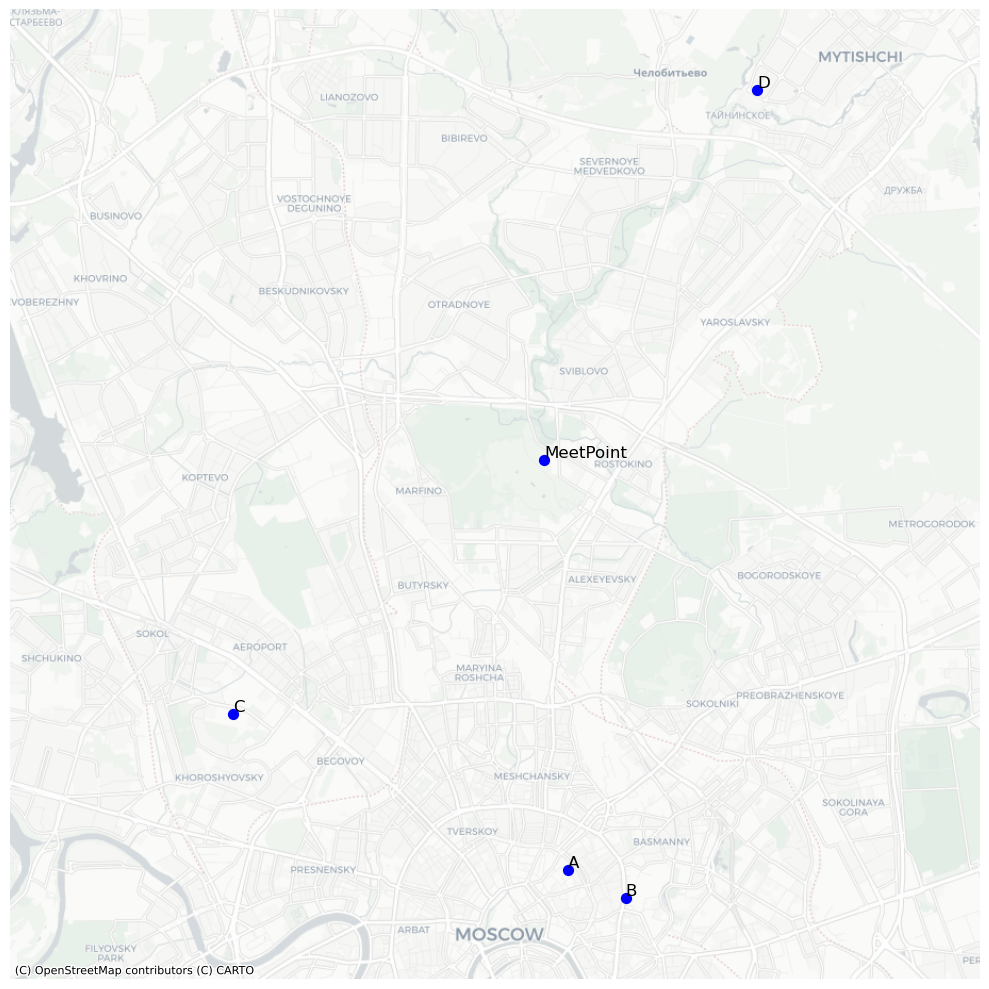

In [1]:
import os

import contextily as cx  # type: ignore
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from routingpy import ORS  # type: ignore
from shapely.geometry import Point, Polygon

"""
Поиск оптимальной точки встречи для трёх людей или более,
которые двигаются пешком по графу.
Точки-прекандидаты располагаются в полигоне, охватывающем всех людей.
Точки-кандидаты располагаются около наилучшей точки из точек прекандидатов.
"""

# TODO:
# Сейчас даже точки кандидатов могу находиться очень далеко друг от друга
# Нужно либо прекандидатов привязать к графу, чтобы они не лежали в промках и уменьшить область поиска для кандидатов
# Либо отбирать кандидатов не рандомные точки, а POI в зависомости от сценария.
# А лучше и то и другое, особенно если первый шаг не затратный по времени.
# Второй шаг в OSM можно сделать как отобрать POI по количеству заполненных атрибутов.

# Публичный сервер Valhalla не поддерживает выдачу матрицы с более 700 (примерно) элементов
# Поднимать локально Valhalla было некогда, поэтому перешли на ORS. Он поддерживает до 3500 элементов матрицы.
ORS_API_KEY = os.getenv("ORS_API_KEY")
service_matrix_limit = 3500

# Блок 1: Зададим местоположение людей
people_points = [
    Point(37.639478, 55.762200),
    Point(37.658026, 55.757094),
    Point(37.531429, 55.790507),
    Point(37.700379, 55.903512),
]

# Блок 2: Создадим точки-прекандидаты оптимальной точки встречи
# Создаем полигон, охватывающий всех троих, в котором будем плодить точки прекандидатов
gdf_first_search_area = gpd.GeoDataFrame(
    geometry=[Polygon([(p.x, p.y) for p in people_points])],
    crs="EPSG:4326",
)
gdf_first_search_area = gdf_first_search_area.to_crs(
    gdf_first_search_area.estimate_utm_crs()
)
# Сперва был попробован буфер в 1000 метров, но его охват не всегда рационален
# поэтому решено было использовать оболочку
gdf_first_search_area = gpd.GeoDataFrame(geometry=gdf_first_search_area.envelope)

# Построим регулярную сетку точек с таким шагом, чтобы суммарный размер матрицы не превышал лимиты сервиса
minx, miny, maxx, maxy = gdf_first_search_area.iloc[0].geometry.bounds
width = maxx - minx
height = maxy - miny

max_points = service_matrix_limit / len(people_points)
approx_step = np.sqrt(1 / max_points)
approx_step = np.clip(
    approx_step, 0.01, 0.2
)  # ограничим шаг пределами (не чаще 1% от ширины/высоты и не реже 20%)
# Теперь шаг в метрах = процент от ширины/высоты
x_step = width * approx_step
y_step = height * approx_step
x_pre_coords = np.arange(minx, maxx, x_step)
y_pre_coords = np.arange(miny, maxy, y_step)

# Строим сетку кандидатов
pre_candidates = []
for x in x_pre_coords:
    for y in y_pre_coords:
        p = Point(float(x), float(y))
        if gdf_first_search_area.iloc[0].geometry.contains(p):
            pre_candidates.append(p)

gdf_pre_candidates = gpd.GeoDataFrame(
    geometry=pre_candidates, crs=gdf_first_search_area.crs
).to_crs("EPSG:4326")
pre_candidates = list(gdf_pre_candidates.geometry.values)

# Блок 3: Найдём лучшую точку среди прекандидатов
# Инициализация клиента ORS
client = ORS(
    api_key=ORS_API_KEY,
    timeout=10,
    retry_timeout=60,
    retry_over_query_limit=True,
    skip_api_error=True,
)

# Построение матрицы
start_points = [[p.x, p.y] for p in people_points]
targets = [[p.x, p.y] for p in pre_candidates]
matrix = client.matrix(
    locations=start_points + targets,
    profile="foot-walking",
    sources=list(range(len(start_points))),
    destinations=list(range(len(start_points), len(start_points) + len(targets))),
    metrics=["duration"]
)

# Блок 4: Поиск оптимальной точки среди прекандидатов
# Получим значения времени для пути из всех точек до всех прекандидатов
all_durations = []
for i in range(len(people_points)):
    all_durations.append(matrix.durations[i])

# Ищем minimax
best_idx = None
best_val = None
best_idx = np.argmin(np.max(all_durations, axis=0))
best_val = np.max(all_durations, axis=0)[best_idx]
best_pre_meetpoint = pre_candidates[best_idx]

# Блок 5: Вокруг точки прекандидата построим точки кандидатов
# Построим немного точек с захватом всего 2 соседних точек прекандидатов
max_buffer_radius = np.ceil(max(x_step, y_step) * 2)
gdf_best_pre_meetpoint = gpd.GeoDataFrame(
    geometry=[Point(best_pre_meetpoint)],
    crs="EPSG:4326",
)
gdf_best_pre_meetpoint = gpd.GeoDataFrame(
    geometry=gdf_best_pre_meetpoint.to_crs(
        gdf_first_search_area.estimate_utm_crs()
    ).buffer(max_buffer_radius)
)

gdf_second_search_area = gpd.GeoDataFrame(geometry=gdf_best_pre_meetpoint.envelope)
minx, miny, maxx, maxy = gdf_second_search_area.iloc[0].geometry.bounds
width = maxx - minx
height = maxy - miny
max_points = service_matrix_limit / len(people_points)
approx_step = np.sqrt(1 / max_points)
approx_step = np.clip(approx_step, 0.01, 0.2)
x_step = width * approx_step
y_step = height * approx_step
x_coords = np.arange(minx, maxx, x_step)
y_coords = np.arange(miny, maxy, y_step)

candidates = []
for x in x_coords:
    for y in y_coords:
        p = Point(float(x), float(y))
        if gdf_second_search_area.iloc[0].geometry.contains(p):
            candidates.append(p)

gdf_candidates = gpd.GeoDataFrame(
    geometry=candidates, crs=gdf_second_search_area.crs
).to_crs("EPSG:4326")
candidates = list(gdf_candidates.geometry.values)

# Блок 6: Построение матрицы для кандидатов и поиск оптимальной точки среди них
start_points = [[p.x, p.y] for p in people_points]
targets = [[p.x, p.y] for p in candidates]
matrix = client.matrix(
    locations=start_points + targets,
    profile="foot-walking",
    sources=list(range(len(start_points))),
    destinations=list(range(len(start_points), len(start_points) + len(targets))),
    metrics=["duration"]
)

all_durations = []
for i in range(len(people_points)):
    all_durations.append(matrix.durations[i])

best_idx = None
best_val = None
best_idx = np.argmin(np.max(all_durations, axis=0))
best_val = np.max(all_durations, axis=0)[best_idx]
best_meetpoint = candidates[best_idx]


# Блок 7: Результаты
# Выводим информацию о оптимальной точке встречи
print(
    "Оптимальная точка встречи:",
    (round(best_meetpoint.y, 6), round(best_meetpoint.x, 6)),
)
times_from_people = [all_durations[i][best_idx] / 60 for i in range(len(people_points))]
print(
    "Время от каждого человека: "
    + ", ".join(
        [
            f"от {chr(65 + i)}: {time:.1f} мин"
            for i, time in enumerate(times_from_people)
        ]
    )
)

# Визуализируем результат на карте
gdf = gpd.GeoDataFrame(
    {"role": [chr(65 + i) for i in range(len(people_points))] + ["MeetPoint"]},
    geometry=[p for p in people_points] + [best_meetpoint],
    crs="EPSG:4326",
)
gdf_web = gdf.to_crs("EPSG:3857")

fig, ax = plt.subplots(figsize=(10, 10))

# Зададим границы области отображения квадратными и с запасом
# Это необходимо для случаев когда точки расположены примерно на одной линии
xmin, ymin, xmax, ymax = gdf_web.total_bounds
xrange = float(xmax - xmin)
yrange = float(ymax - ymin)
buffer = max(xrange, yrange) * 0.2
max_range = max(xrange, yrange) + buffer
xmid = (xmin + xmax) / 2
ymid = (ymin + ymax) / 2
xmin, xmax = xmid - max_range / 2, xmid + max_range / 2
ymin, ymax = ymid - max_range / 2, ymid + max_range / 2
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

cx.add_basemap(ax, crs=gdf_web.crs, source=cx.providers.CartoDB.Positron)
gdf_web.plot(ax=ax, color="blue", markersize=50)
# Подписи для точек
for x, y, label in zip(gdf_web.geometry.x, gdf_web.geometry.y, gdf_web["role"]):
    ax.text(float(x), float(y), label, fontsize=12, va="bottom", color="black")
ax.set_axis_off()
plt.tight_layout()
plt.show()